### _setup_

In [20]:
# !pip uninstall -y pyupset
# !pip install https://github.com/agitter/py-upset/archive/master.zip

In [21]:
# 
# we need a python2 version of pyupset
# !pip uninstall -y pyupset
# !pip install https://github.com/agitter/py-upset/archive/master.zip
# !pip install seaborn

from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, A, Q , aggs, query

from collections import Counter, defaultdict
import pandas as pd
import pyupset as pyu
import re
import itertools
import json
from IPython.display import set_matplotlib_formats
from collections import namedtuple
from __future__ import division
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

#  The resulting plots will then also be stored in the notebook document.
%matplotlib inline

# connect to elastic
HOST = ['elastic:9200']
client = Elasticsearch(HOST)
# validate connection
assert(client.info()['version'])

# Total Associations
### For all G2P sources, show the counts and overlaps


In [22]:
# Use DSL to aggregate counts on the server
s = Search(using=client, index="associations")
# limit query to 1K sources, 1M genes each
s.aggs.bucket('source', 'terms', field='source.keyword', size=1000) \
      .bucket('genes', 'terms',field='genes.keyword', size=1000000)
aggregation = s.execute()
# Create dataframe to hold results
gene_counts = pd.DataFrame([ {'source':source.key,
                     'evidence_count': source.doc_count,
                     'genes_count': len(source.genes.buckets),
                     'genes':[ {'gene': gene.key, 'count': gene.doc_count}
                        for gene in source.genes.buckets
                     ],
                     'gene_names': [gene.key for gene in source.genes.buckets]
                    } 
                    for source in aggregation.aggregations.source.buckets])
gene_counts = gene_counts.set_index('source')
gene_counts[['evidence_count', 'genes_count', 'genes','gene_names']]


,evidence_count,genes_count,genes,gene_names
source,,,,
molecularmatch_trials,206138,998,"[{u'count': 29874, u'gene': u'EGFR'}, {u'count...","[EGFR, VEGFA, PDCD1, CD274, PDCD1LG2, MS4A1, A..."
brca,5733,2,"[{u'count': 3406, u'gene': u'BRCA2'}, {u'count...","[BRCA2, BRCA1]"
jax,5264,187,"[{u'count': 508, u'gene': u'EGFR'}, {u'count':...","[EGFR, ALK, ERBB2, KRAS, BRAF, PIK3CA, KIT, TP..."
oncokb,4149,276,"[{u'count': 295, u'gene': u'BRCA1'}, {u'count'...","[BRCA1, KIT, EGFR, TP53, BRAF, PTEN, BRCA2, PD..."
civic,3176,292,"[{u'count': 329, u'gene': u'KRAS'}, {u'count':...","[KRAS, VHL, ABL1, EGFR, BRAF, ALK, PIK3CA, ERB..."
molecularmatch,2079,111,"[{u'count': 446, u'gene': u'KRAS'}, {u'count':...","[KRAS, EGFR, PIK3CA, ESR1, MET, ALK, ERBB2, BR..."
cgi,1431,183,"[{u'count': 153, u'gene': u'EGFR'}, {u'count':...","[EGFR, ABL1, ERBB2, BRAF, NF1, ALK, KRAS, KIT,..."
jax_trials,1131,58,"[{u'count': 355, u'gene': u'ERBB2'}, {u'count'...","[ERBB2, EGFR, BRAF, ALK, KRAS, BRCA1, BRCA2, N..."
pmkb,609,42,"[{u'count': 72, u'gene': u'SF3B1'}, {u'count':...","[SF3B1, KRAS, BRAF, CTNNB1, PIK3CA, EGFR, FLT3..."


# Genes Overlap
### For each source, list the count of genes that overlap

In [23]:
# lightweight class
Overlap = namedtuple('Overlap', ['other', 'source', 'size', 'percentage', 'other_size', 'source_size',
                                 'other_gene_names' ])

# intersection
def genes_intersection(df1, df2):
    return set(df1.gene_names) & set(df2.gene_names)

# comparison of source to all other sources
def source_intersection(source):
    others = set(gene_counts.index.tolist()) - set([source])
    for other in others:
        overlap_size = len(genes_intersection(gene_counts.loc[source], gene_counts.loc[other]))
        other_size = len(gene_counts.loc[other].gene_names)
        yield Overlap(other=other,
                      source=source,
                      size=overlap_size,
                      other_size=other_size,
                      source_size=len(gene_counts.loc[source].gene_names),
                      percentage=(overlap_size / other_size) * 100,
                      other_gene_names=set(gene_counts.loc[other].gene_names)
                     ) 

overlaps = [] # for plotting
print('overall overlap')
for source in gene_counts.index.tolist():
    total = set()
    for overlap in source_intersection(source):
        overlaps.append(overlap)  # for plotting
        total |= overlap.other_gene_names  # for overall
        print('    {} {}/{} ({:.2f}%) overlap with {}'.format(source, overlap.size,
                                                           overlap.other_size,
                                                           overlap.percentage,
                                                           overlap.other))
    overall = set(gene_counts.loc[source].gene_names) & total
    print('  {}: {}/{} ({:.2f}%)'.format(source, len(overall), len(total), len(overall) / len(total)* 100))
    

overall overlap
    molecularmatch_trials 154/183 (84.15%) overlap with cgi
    molecularmatch_trials 74/187 (39.57%) overlap with jax
    molecularmatch_trials 197/292 (67.47%) overlap with civic
    molecularmatch_trials 2/2 (100.00%) overlap with sage
    molecularmatch_trials 107/111 (96.40%) overlap with molecularmatch
    molecularmatch_trials 201/276 (72.83%) overlap with oncokb
    molecularmatch_trials 40/42 (95.24%) overlap with pmkb
    molecularmatch_trials 54/58 (93.10%) overlap with jax_trials
    molecularmatch_trials 2/2 (100.00%) overlap with brca
  molecularmatch_trials: 317/604 (52.48%)
    brca 2/183 (1.09%) overlap with cgi
    brca 2/187 (1.07%) overlap with jax
    brca 2/292 (0.68%) overlap with civic
    brca 2/276 (0.72%) overlap with oncokb
    brca 2/998 (0.20%) overlap with molecularmatch_trials
    brca 2/111 (1.80%) overlap with molecularmatch
    brca 0/2 (0.00%) overlap with sage
    brca 0/42 (0.00%) overlap with pmkb
    brca 2/58 (3.45%) overlap with

# Gene overlap (percentage)

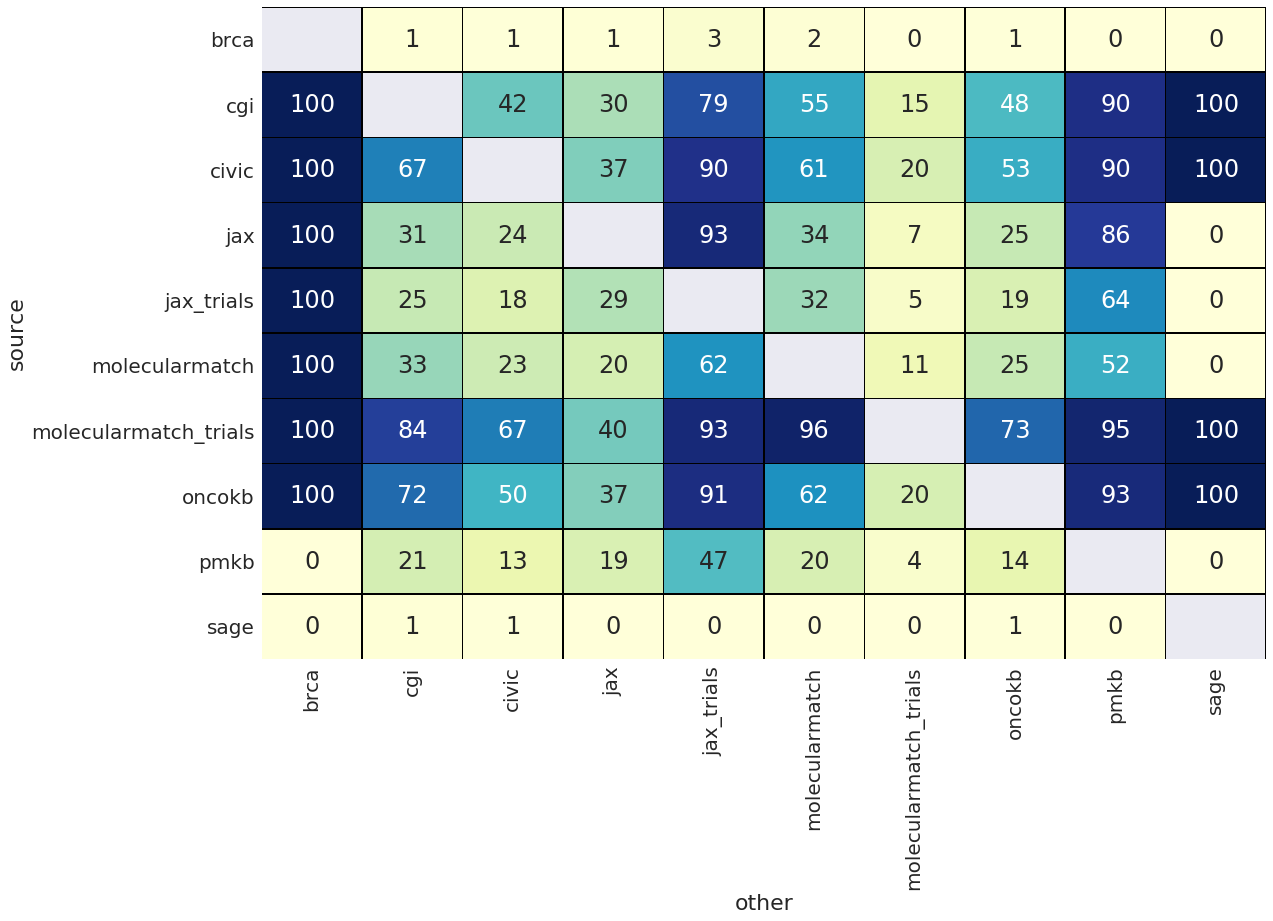

In [24]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.set(font_scale=2)
# Load the overlaps into pd and pivot
overlaps_hm = pd.DataFrame(overlaps).pivot("source", "other", "percentage")
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(overlaps_hm, annot=True, fmt="1.0f", linewidths=.5, ax=ax, cbar=False, cmap="YlGnBu",linecolor='black') 


# Harmonization results

In [25]:
# Use DSL to aggregate counts on the server
# query prototyped in kibana
q='{"query":{"query_string":{"analyze_wildcard":true,"query":"*"}},"size":0,"_source":{"excludes":[]},"aggs":{"source":{"terms":{"field":"source.keyword","size":1000,"order":{"_count":"desc"}},"aggs":{"harmonization":{"filters":{"filters":{"missing_disease_ontology":{"query_string":{"query":"\\"no-doid\\""}},"all":{"query_string":{"analyze_wildcard":true,"query":"*"}},"missing_pubchem":{"query_string":{"query":"\\"no-pubchem\\""}},"missing_genomic_location":{"query_string":{"query":"_exists_:features.description AND NOT _exists_:features.start"}},"missing_biomarker":{"query_string":{"query":"_exists_:features.description AND NOT _exists_:features.biomarker_type.keyword"}},"gene_only":{"query_string":{"query":"NOT _exists_:features.name"}}}}}}}}}'
res = client.search(index="associations", doc_type="association", body=json.loads(q))


In [26]:
# Make aggregations panda friendly
def convert(dictionary):
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

harmonization_results = []
for bucket in res['aggregations']['source']['buckets']:    
    o = {}
    b = bucket['harmonization']['buckets']
    o['source'] = bucket['key']
    for key in [k for k in b]:
      o[key] = b[key]['doc_count']
    harmonization_results.append(convert(o))
harmonization_results = pd.DataFrame(harmonization_results)
harmonization_results = harmonization_results.set_index('source')
harmonization_results

,all,missing_disease_ontology,gene_only,missing_pubchem,missing_biomarker,missing_genomic_location
source,,,,,,
molecularmatch_trials,206138,22,76932,4813,14670,54477
brca,5733,0,0,0,0,0
jax,5264,1,0,280,0,0
oncokb,4149,16,0,24,0,239
civic,3176,38,0,27,0,0
molecularmatch,2079,1,149,31,0,0
cgi,1431,107,0,140,0,842
jax_trials,1131,0,0,31,0,0
pmkb,609,51,0,0,0,0


# Harmonization results

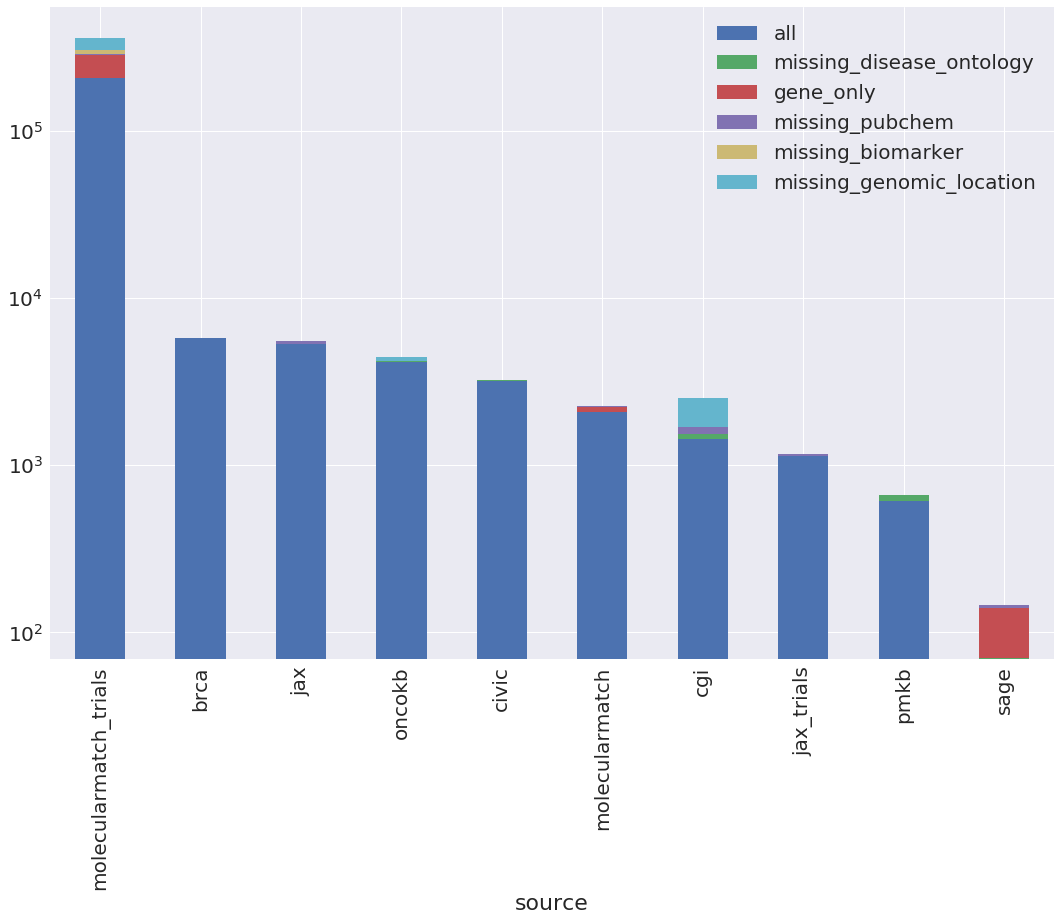

In [27]:
harmonization_results.plot(kind='bar',log=True, stacked=True, figsize=(18, 12))

In [28]:

fully_harmonized = {}
# get count per source
s = Search(using=client, index="associations")
s.aggs.bucket('source', 'terms', field='source.keyword', size=1000) 
aggregation = s.execute()
for bucket in aggregation.aggregations.source.buckets:
    fully_harmonized[bucket['key']] = {'count':bucket['doc_count'],
                                       'source': bucket['key'],
                                       'fully_harmonized': 0
                                      }

# get count per source of fully harmonized evidence
# TODO prefer use of DSL, not raw dict
q= '{"size":0,"query":{"query_string":{"query":"_exists_:features.start AND NOT dev_tags:\\"no-doid\\"  AND NOT dev_tags:\\"no-pubchem\\" ","analyze_wildcard":true}},"_source":{"excludes":[]},"aggs":{"source":{"terms":{"field":"source.keyword","size":1000,"order":{"_count":"desc"}}}}}'

res = client.search(index="associations", doc_type="association", body=json.loads(q))
for bucket in res['aggregations']['source']['buckets']:    
    fully_harmonized[bucket['key']]['fully_harmonized'] = bucket['doc_count']

# xform fully_harmonized to a dataframe  
a = []
for k in fully_harmonized:
    a.append(fully_harmonized[k])
fully_harmonized = pd.DataFrame(a)
fully_harmonized = fully_harmonized.set_index('source')
sum_row=fully_harmonized[["count","fully_harmonized"]].sum()
df_sum=pd.DataFrame(data=sum_row).T
fully_harmonized=fully_harmonized.append(df_sum)
fully_harmonized = fully_harmonized.rename(index={0:"_total"})
fully_harmonized


,count,fully_harmonized
cgi,1431,536
jax,5264,4154
civic,3176,2804
sage,69,0
molecularmatch_trials,206138,73975
molecularmatch,2079,1656
oncokb,4149,1790
pmkb,609,558
jax_trials,1131,1022
brca,5733,5733


In [29]:
print("{:.2f}% of associations are fully normalized across gene, drug, phenotype and feature".format(df_sum.loc[0]['fully_harmonized']/ df_sum.loc[0]['count'] * 100))

40.14% of associations are fully normalized across gene, drug, phenotype and feature


In [30]:
# recalculate without mm_trials
fully_harmonized = fully_harmonized.drop(['molecularmatch_trials', '_total'])
sum_row=fully_harmonized[["count","fully_harmonized"]].sum()
df_sum=pd.DataFrame(data=sum_row).T
fully_harmonized=fully_harmonized.append(df_sum)
fully_harmonized = fully_harmonized.rename(index={0:"_total"})
fully_harmonized

,count,fully_harmonized
cgi,1431,536
jax,5264,4154
civic,3176,2804
sage,69,0
molecularmatch,2079,1656
oncokb,4149,1790
pmkb,609,558
jax_trials,1131,1022
brca,5733,5733
_total,23641,18253


In [31]:
print("{:.2f}% of associations (excluding molecularmatch_trials) are fully normalized across gene, feature, drug, phenotype".format(df_sum.loc[0]['fully_harmonized']/ df_sum.loc[0]['count'] * 100))


77.21% of associations (excluding molecularmatch_trials) are fully normalized across gene, feature, drug, phenotype


# Variant overlap

In [32]:

def feature_hash(f):
    """ given a feature, hash it"""
    return hashlib.md5(json.dumps(f.to_dict(), sort_keys=True).encode('utf-8')).hexdigest()

def aggregate_hit(o, hit):
    """ create a list of feature hashes"""
    if hit.source not in o:
        o[hit.source] = {'features': set([])}
    features =  o[hit.source]['features']
    o[hit.source]['features'] = set(list(features) + [feature_hash(f) for f in hit.features])


# Use DSL to query genomic location, subset of fields 
s = Search(using=client, index="associations") \
  .params(size=1000) \
  .query("query_string", query="_exists_:features.referenceName") \
  .source(include=['source', 'features.referenceName', 'features.chromosome',
                   'features.start','features.end','features.ref','features.alt'])

# create a {source:<name> , features:[<hashed>]}
aggregate_hits = {}
for hit in s.scan():    
    aggregate_hit(aggregate_hits, hit)

total = 0
for k in aggregate_hits.keys():
    total = total + len(aggregate_hits[k]['features'])
print('Total of {} items with genomic location'.format(total))


# xform aggregate_hits to a dataframe  
features = pd.DataFrame([{'source':k, 'features':list(aggregate_hits[k]['features'])} for k in aggregate_hits]).set_index('source')
features


Total of 11668 items with genomic location


,features
source,
cgi,"[54567b168d0f3a2bf5bfa426782ba96f, 406a95f8c1c..."
jax,"[67a2c22319b791e8f2a439cf8027eb4f, a0f584ccdd8..."
civic,"[796e77069dad811761dc7d728dbb5580, 234b7835ed6..."
molecularmatch_trials,"[b9fb1d3fd322faee5a9d696de5c523f1, 7a9ac4e2985..."
molecularmatch,"[3b854251b9a11cf6cb2a78dfb37e4a74, a0f584ccdd8..."
oncokb,"[a9c3740405a4b57101c0b070d966ae44, 3583038a8a7..."
pmkb,"[3243b6c2e4388b86da21bee2e4fd291d, 4622aa2a9e5..."
jax_trials,"[4622aa2a9e576fb4f46e19e4984c8cc8, 1c751978558..."
brca,"[03f6cd6dca6bc466e4a7886ec9a0d037, 8e5d4f8fef8..."


In [33]:
# lightweight class
Overlap = namedtuple('Overlap', ['other', 'source', 'size', 'percentage', 'other_size', 'source_size',
                                 'other_features' ])

# intersection
def features_intersection(df1, df2):
    return set(df1.features) & set(df2.features)

# comparison of source to all other sources
def source_intersection(source):
    others = set(features.index.tolist()) - set([source])
    for other in others:
        overlap_size = len(features_intersection(features.loc[source], features.loc[other]))
        other_size = len(features.loc[other].features)
        yield Overlap(other=other,
                      source=source,
                      size=overlap_size,
                      other_size=other_size,
                      source_size=len(features.loc[source].features),
                      percentage=(overlap_size / other_size) * 100,
                      other_features=set(features.loc[other].features)
                     ) 

overlaps = [] # for plotting
print('overall overlap')
for source in features.index.tolist():
    total = set()
    for overlap in source_intersection(source):
        overlaps.append(overlap)  # for plotting
        total |= overlap.other_features  # for overall
        print('        {} {}/{} ({:.2f}%) overlap with {}'.format(source, overlap.size,
                                                                   overlap.other_size,
                                                                   overlap.percentage,
                                                                   overlap.other))
    overall = set(features.loc[source].features) & total
    print('  {}: {}/{} ({:.2f}%)'.format(source, len(overall), len(total), len(overall) / len(total)* 100))
    

overall overlap
        cgi 0/493 (0.00%) overlap with jax
        cgi 0/698 (0.00%) overlap with civic
        cgi 1/1974 (0.05%) overlap with molecularmatch_trials
        cgi 0/550 (0.00%) overlap with molecularmatch
        cgi 0/1654 (0.00%) overlap with oncokb
        cgi 0/161 (0.00%) overlap with pmkb
        cgi 0/91 (0.00%) overlap with jax_trials
        cgi 0/5733 (0.00%) overlap with brca
  cgi: 1/10014 (0.01%)
        jax 0/314 (0.00%) overlap with cgi
        jax 107/698 (15.33%) overlap with civic
        jax 165/1974 (8.36%) overlap with molecularmatch_trials
        jax 96/550 (17.45%) overlap with molecularmatch
        jax 298/1654 (18.02%) overlap with oncokb
        jax 20/161 (12.42%) overlap with pmkb
        jax 83/91 (91.21%) overlap with jax_trials
        jax 0/5733 (0.00%) overlap with brca
  jax: 377/10211 (3.69%)
        civic 0/314 (0.00%) overlap with cgi
        civic 107/493 (21.70%) overlap with jax
        civic 125/1974 (6.33%) overlap with molecul

# Feature overlap (percentage)

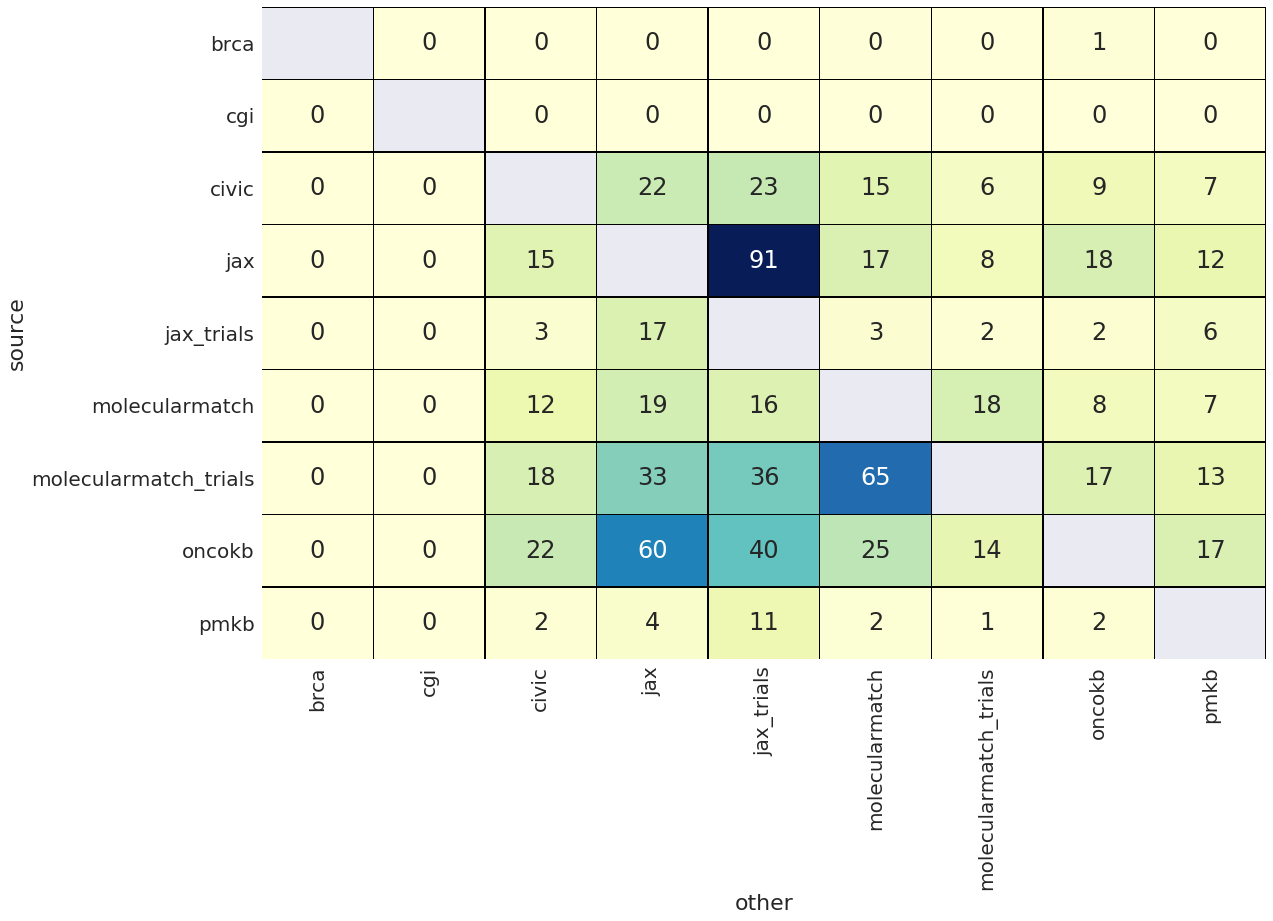

In [34]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.set(font_scale=2)
# Load the overlaps into pd and pivot
overlaps_hm = pd.DataFrame(overlaps).pivot("source", "other", "percentage")
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(overlaps_hm, annot=True, fmt="1.0f", linewidths=.5, ax=ax, cbar=False, cmap="YlGnBu",linecolor='black') 


# Publication

In [35]:

def aggregate_hit(o, hit):
    """ create a list of publications"""
    if hit.source not in o:
        o[hit.source] = {'publications': set([])}
    publications =  o[hit.source]['publications']
    for e in hit.association.evidence:
        for p in e.info.publications:         
            o[hit.source]['publications'].add(p)


# Use DSL to query genomic location, subset of fields 
s = Search(using=client, index="associations") \
  .params(size=1000) \
  .query("query_string", query="_exists_:association.evidence.info.publications") \
  .source(include=['source', 'association.evidence.info.publications'])

# create a {source:<name> , publications:[<urls>]}
aggregate_hits = {}
for hit in s.scan():    
    aggregate_hit(aggregate_hits, hit)

total = 0
for k in aggregate_hits.keys():
    total = total + len(aggregate_hits[k]['publications'])
print('Total of {} items with publications'.format(total))


# xform aggregate_hits to a dataframe  
publications = pd.DataFrame([{'source':k, 'publications':list(aggregate_hits[k]['publications'])} for k in aggregate_hits]).set_index('source')
publications

Total of 29433 items with publications


,publications
source,
cgi,"[http://www.ncbi.nlm.nih.gov/pubmed/22711857, ..."
jax,"[, http://www.ncbi.nlm.nih.gov/pubmed/24573551..."
civic,"[http://www.ncbi.nlm.nih.gov/pubmed/23619944, ..."
sage,"[https://www.ncbi.nlm.nih.gov/pubmed/25878190,..."
molecularmatch_trials,[https://clinicaltrials.gov/ct2/show/NCT023383...
molecularmatch,"[, https://www.ncbi.nlm.nih.gov/pubmed/1472905..."
oncokb,"[http://www.ncbi.nlm.nih.gov/pubmed/8162068, h..."
pmkb,"[http://www.ncbi.nlm.nih.gov/pubmed/22273505, ..."
jax_trials,[https://clinicaltrials.gov/ct2/show/NCT016591...


In [36]:
# lightweight class
Overlap = namedtuple('Overlap', ['other', 'source', 'size', 'percentage', 'other_size', 'source_size',
                                 'other_publications' ])

# intersection
def publications_intersection(df1, df2):
    return set(df1.publications) & set(df2.publications)

# comparison of source to all other sources
def source_intersection(source):
    others = set(publications.index.tolist()) - set([source])
    for other in others:
        overlap_size = len(publications_intersection(publications.loc[source], publications.loc[other]))
        other_size = len(publications.loc[other].publications)
        yield Overlap(other=other,
                      source=source,
                      size=overlap_size,
                      other_size=other_size,
                      source_size=len(publications.loc[source].publications),
                      percentage=(overlap_size / other_size) * 100,
                      other_publications=set(publications.loc[other].publications)
                     ) 

overlaps = [] # for plotting
print('overall overlap')
for source in publications.index.tolist():
    total = set()
    for overlap in source_intersection(source):
        overlaps.append(overlap)  # for plotting
        total |= overlap.other_publications  # for overall
        print('        {} {}/{} ({:.2f}%) overlap with {}'.format(source, overlap.size,
                                                                   overlap.other_size,
                                                                   overlap.percentage,
                                                                   overlap.other))
    overall = set(publications.loc[source].publications) & total
    print('  {}: {}/{} ({:.2f}%)'.format(source, len(overall), len(total), len(overall) / len(total)* 100))
   

overall overlap
        cgi 152/1599 (9.51%) overlap with jax
        cgi 180/1554 (11.58%) overlap with civic
        cgi 140/3159 (4.43%) overlap with oncokb
        cgi 0/20256 (0.00%) overlap with molecularmatch_trials
        cgi 0/528 (0.00%) overlap with molecularmatch
        cgi 0/67 (0.00%) overlap with sage
        cgi 19/337 (5.64%) overlap with pmkb
        cgi 0/1131 (0.00%) overlap with jax_trials
        cgi 0/9 (0.00%) overlap with brca
  cgi: 317/27018 (1.17%)
        jax 152/793 (19.17%) overlap with cgi
        jax 228/1554 (14.67%) overlap with civic
        jax 193/3159 (6.11%) overlap with oncokb
        jax 0/20256 (0.00%) overlap with molecularmatch_trials
        jax 2/528 (0.38%) overlap with molecularmatch
        jax 0/67 (0.00%) overlap with sage
        jax 32/337 (9.50%) overlap with pmkb
        jax 0/1131 (0.00%) overlap with jax_trials
        jax 0/9 (0.00%) overlap with brca
  jax: 424/26319 (1.61%)
        civic 180/793 (22.70%) overlap with cgi
  

# Publication overlap (percentage)

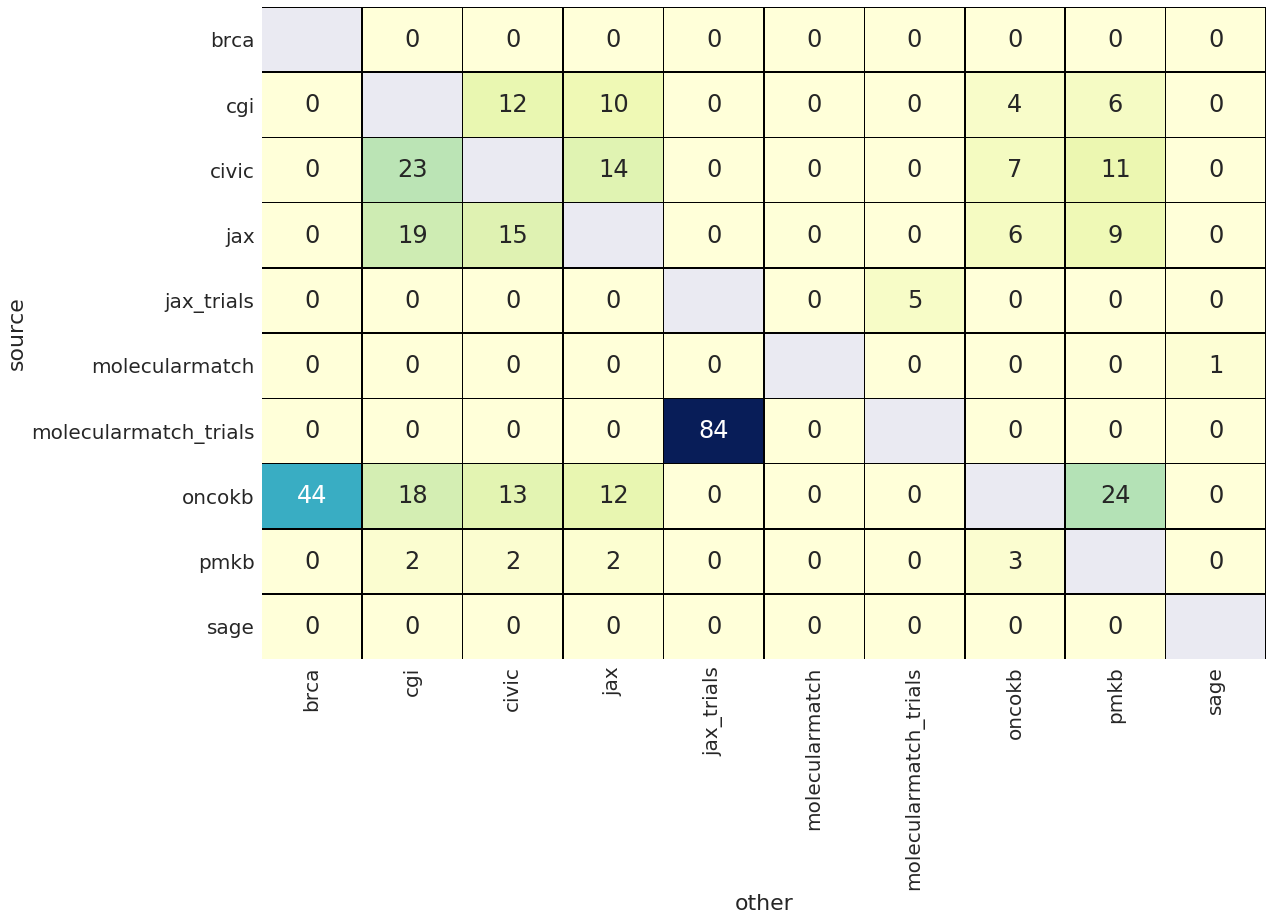

In [37]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.set(font_scale=2)
# Load the overlaps into pd and pivot
overlaps_hm = pd.DataFrame(overlaps).pivot("source", "other", "percentage")
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(overlaps_hm, annot=True, fmt="1.0f", linewidths=.5, ax=ax, cbar=False, cmap="YlGnBu",linecolor='black') 
